# Test Project - Computational Finance

## Complete Market Models & Pricing Library
Date: 2023-03-02
Author: Alexander Nadjalin

This is the solution for the test project in Computational Finance for The Pyton Quants Platinum Certificate Program, January 2023 cohort.

## Task
Write a pricing library for European plain vanilla and exotic options making use of geometric Brownian motion as the stochastic process. The pricing shall be based on Monte Carlo simulation.

The pricing library shall have:

* a class for the risk-neutral discounting (taking the short rate as parameter, generating discount factors as required, etc.)
* a class to model the parameters of the underyling risk factor and a European option (initial value, volatility, time-to-maturity, dividends, strike price, option type etc.)
* a class to value European vanilla options based on Monte Carlo simulation
* a class to value European lookback options — with either fixed or floating strike (see https://en.wikipedia.org/wiki/Lookback_option)
* a class to value European Asian options — with either fixed price or fixed strike (see https://en.wikipedia.org/wiki/Asian_option)

## About this notebook

### Assumptions
* We are working under the risk neutral density $Q$.
* Dividends (if any) are paid, they are constant and denoted $\delta$. Dividends $S_{t} \delta \Delta t$ are paid at $\Delta t$.
* Asian option average period is the whole length of time. There is no weighting factor.
### Error handling
* There is no error handling or warnings included in this solution.
### Code
* The code in this Notebook is not optimized in any way.
* The code complies with the PEP8 standards.

## The underlying stock price

In this section we look at how to model the underlying stock price.

### The dynamics
The underlying stock price follows a arithmetic Brownian motion (GBM)

$$
\begin{align}
dS_t = (r - \delta) S_t dt + \sigma S_t dZ_t
\tag{1}
\end{align}
$$

where:
* $S_0 \in R_{>0}$ is the underlying stock price at time $t$, where $t \equiv \{ t_{0} = 0, t_{1}, t{2},..., t_{M} = T \}$, and $M + 1, M > 1$
* $\Delta t$ is a fixed time length
* $r$ is the constant short rate
* $\delta$ the constant dividend yield (see "Assumptions" above)
* $\sigma \in R_{>0}$ is the constant volatility
* $Z_t$ an arithmetic Brownian motion.

Because we are working under the risk neutral density $Q$, $\mu$ is replaced by the risk-free rate as part of the no-arbitrage assumption. The drift part of equation above is $r S_t$ and the diffusion part is $\sigma S_t$.

To represent the return of the underlying stock price $S$, we can model it by using

$$
\begin{align}
\frac{dS}{S} = (r - \delta) dt + \sigma dZ
\tag{2}
\end{align}
$$

However, for this solution, we are not primarily interested in the returns but rather $S_{T}$, where $T$ is the very last point in time.

###  Simulating the GBM
We can use the *Euler discretization* to simulate $S(t)$. The EM is defined from $(2)$ recursively as

$$
\begin{align}
S_t = S_{t - \Delta t} e^{\biggl(\biggl(r - \delta - \frac{\sigma^2}{2} \biggr) \Delta t + \sigma \sqrt{\Delta t} z\biggr)}
\tag{3}
\end{align}
$$

where $z$ is a standard normally distributed random variable. The value of $S$ at time $t$, is dependant on the value of $S$ at time $t - 1$, the random variable $z$, and the constant parameters $\Delta t$, $\sigma$, $r$ and $\delta$.

### Code for simulating the GBM
We introduce a class "MarketMCOption" for all the parameters - market, Monte-Carlo and, the option definition.

Below is the Python code to simulate one complete path of $S$ from $t = 0$ to $t = 1$ with $\Delta t = 1 / 365$. $\Delta t$ is chosen to represent the number of days in a standard year (no leap year).

We start with the imports:

In [99]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Notebook magic commands for plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [100]:
class MarketAndOption:
    """

    Class holding market parameters, simulation parameters and option information.
    """
    def __init__(self,
                 s0: float,
                 div: float,
                 sigma: float,
                 r: float,
                 expiry: float,
                 k: float,
                 num_steps: int,
                 num_sims: int):
        """

        Initializing class.
        @param s0: Underlying stock price at time t0.
        @param div: Dividends (as a continuous yield).
        @param sigma: Constant volatility (in decimal form).
        @param r: Constant short rate (in decimal form).
        @param expiry: Time to expiry (in years).
        @param k: Option strike level.
        @param num_steps: Number of steps in each Monte-Carlo simulation.
        @param num_sims:Number om Monte-Carlo simulations.
        """
        self.s0 = s0
        self.div = div
        self.sigma = sigma
        self.r = r
        self.expiry = expiry
        self.k = k
        self.num_steps = num_steps
        self.num_sims = num_sims
        self.dt = expiry / num_steps
        self.mc_paths = None

        # Run the Monte-Carlo simulation.
        self.mc_sim()

        # Holder for plot.
        self.plot = None

    def mc_sim(self) -> None:
        """

        Monte-Carlo simulation.
        @return: None.
        """
        # Pre-simulation setup.
        rand_s = np.random.standard_normal((self.num_steps, self.num_sims))
        self.mc_paths = np.zeros_like(rand_s)
        # Set s0 as first value.
        self.mc_paths[0] = self.s0

        # The Euler discretization for all time steps.
        for t in range(1, self.num_steps):
            self.mc_paths[t] = self.mc_paths[t - 1] * \
                               np.exp((self.r - self.div - self.sigma ** 2 / 2) * self.dt +
                                      self.sigma * math.sqrt(self.dt) * rand_s[t])

    def plot_paths(self) -> None:
        """

        Plot all paths.
        @return: None.
        """
        plt.figure(figsize=(15, 12))
        plt.plot(self.mc_paths)
        plt.title('Euler discretization scheme')
        plt.ylabel('S')
        plt.xlabel('$\Delta_t$')
        plt.grid(True)
        plt.axis('tight')

        self.plot = plt
        self.plot.show()

We can now initiate the MarketAndOption with some starting parameters. We keep the number of paths low in order to save time making the plot.

In [101]:
s0 = 36
div = 0.0
sigma = 0.2
r = 0.06
expiry = 1
k = 40
num_steps = 100
num_sims = 100

M = MarketAndOption(s0=s0,
                   div=div,
                   sigma=sigma,
                   r=r,
                   expiry=expiry,
                   k=k,
                   num_steps=num_steps,
                   num_sims=num_sims)

We can now plot all the paths using the class method *plot_paths()*:

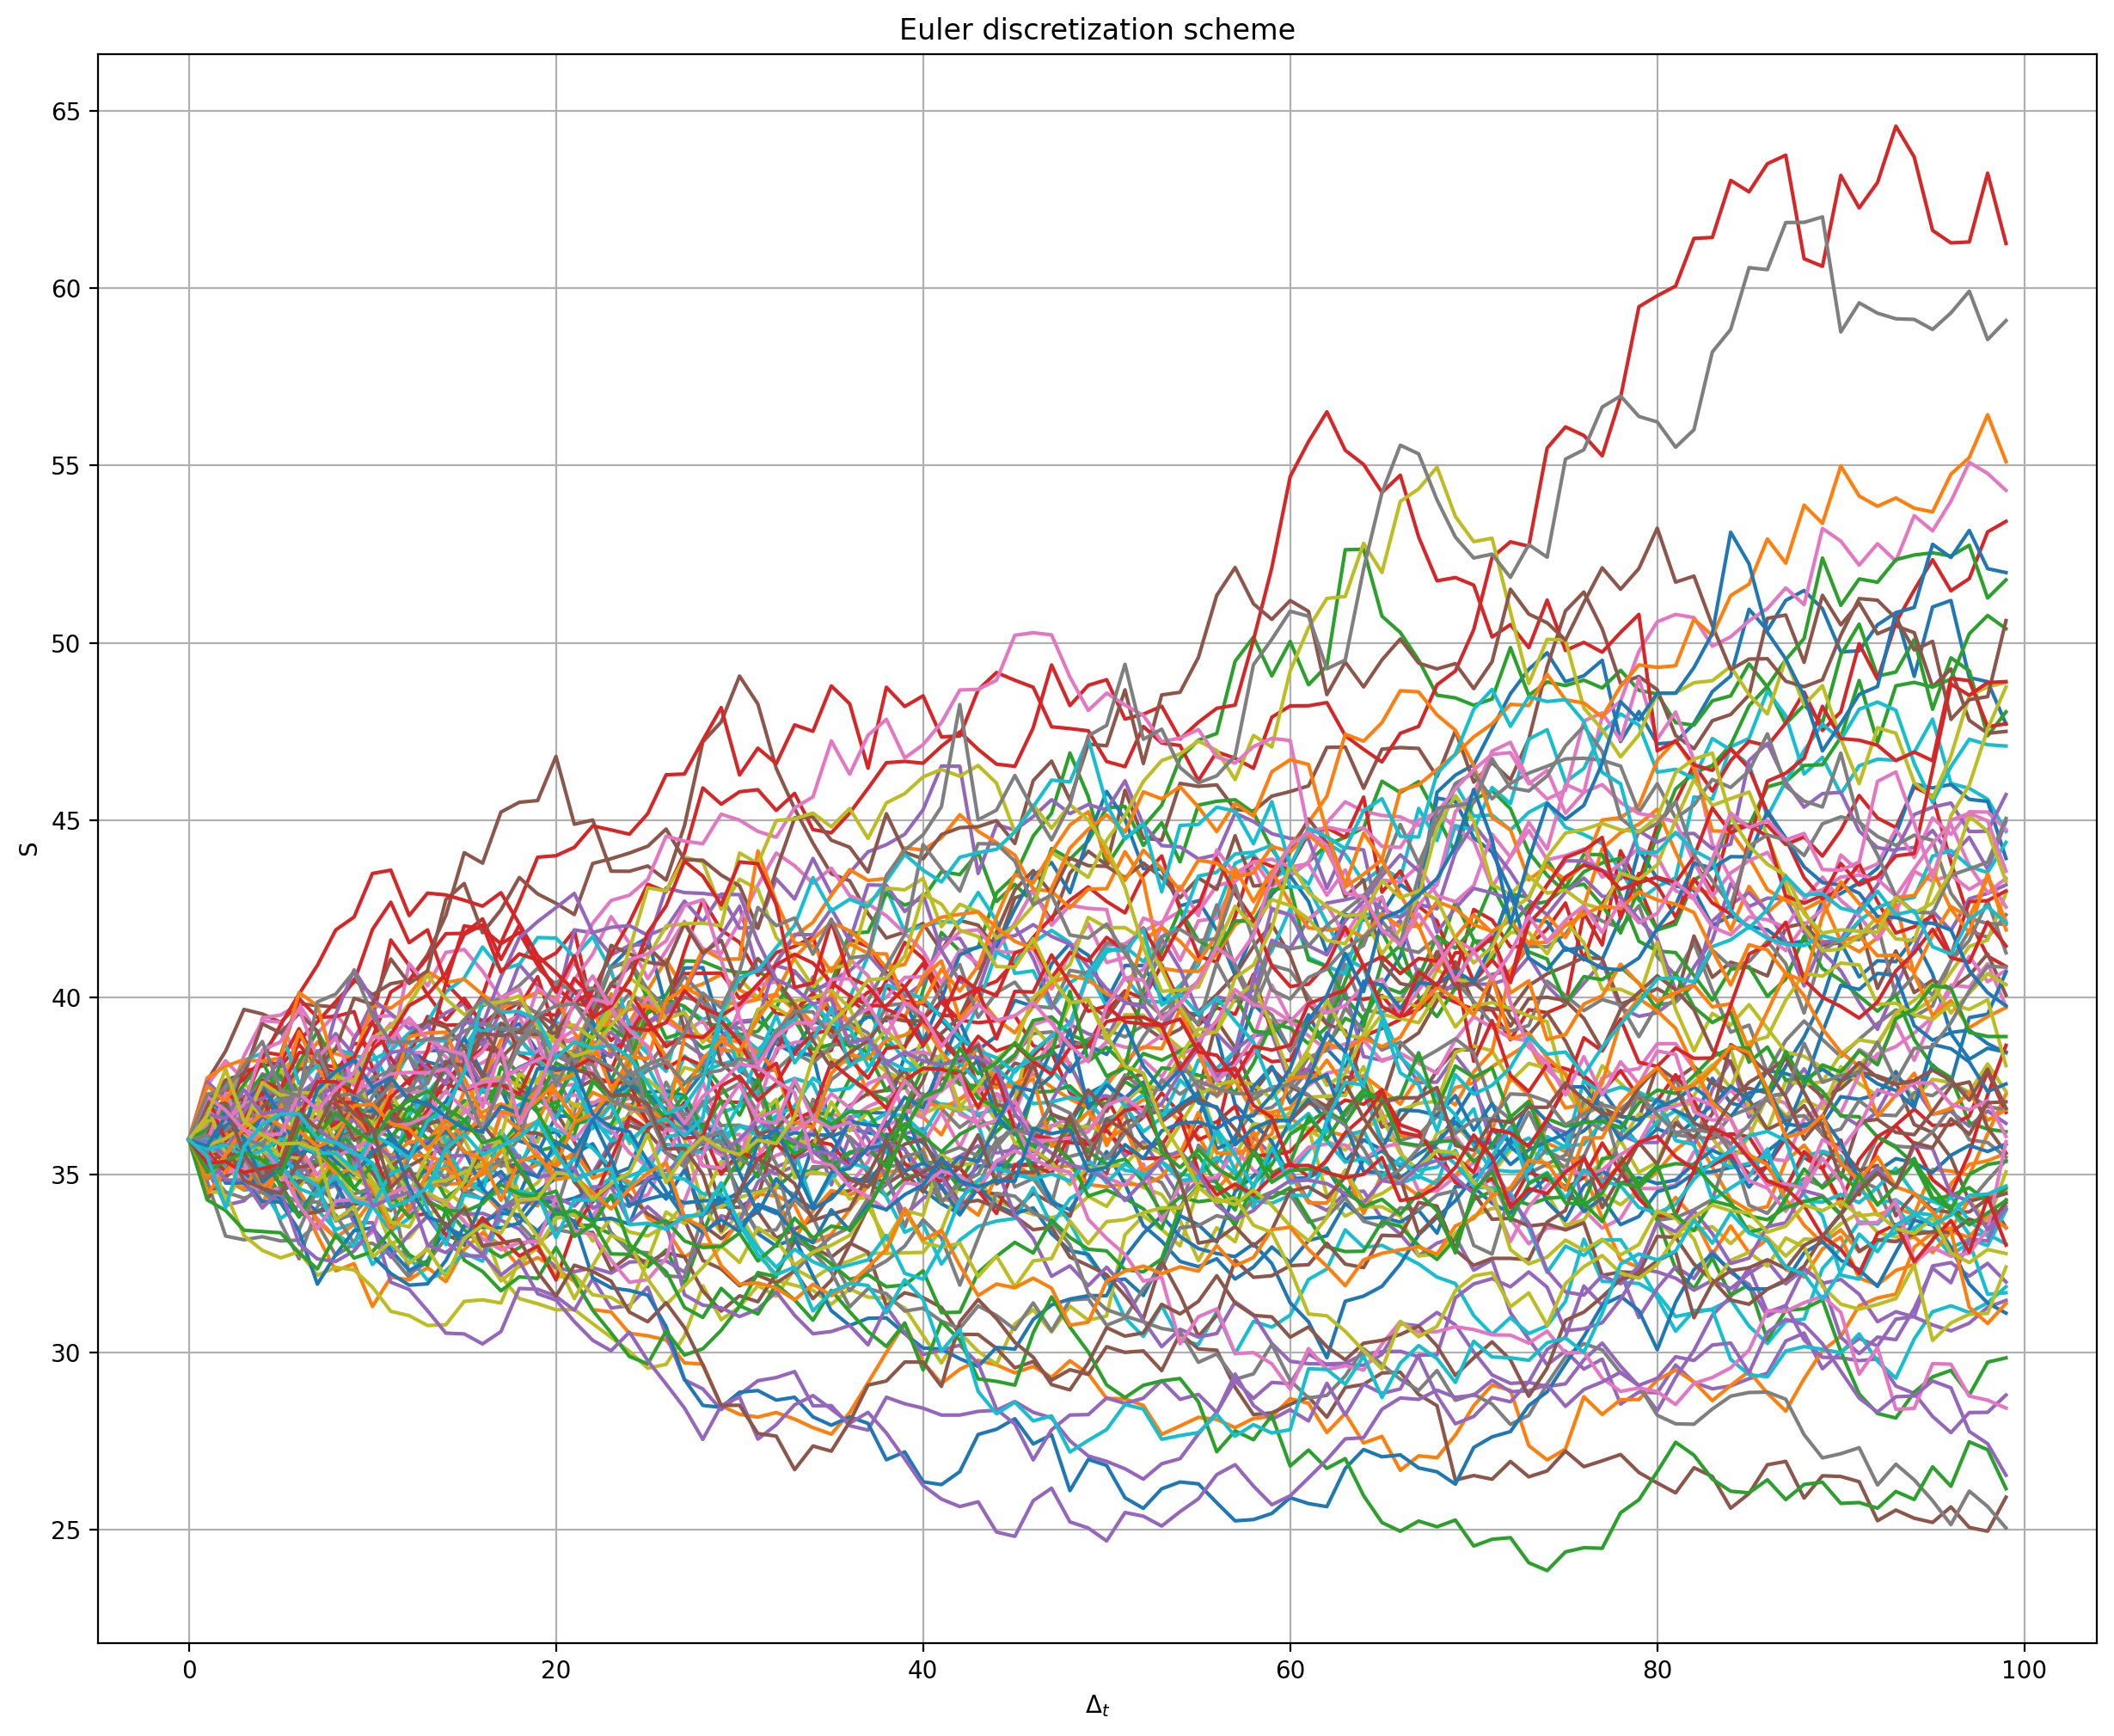

In [102]:
M.plot_paths()

## Numerical procedure

This describes in short the structure of the code for the solution.

* We define our parameters for the class MarketMCOption (showed above).

* We set up a loop to run for the number of simulations
    * For each simulation we generate a GBM using the Euler discretization.
      * We use the very last simulated value of $S$ (at time $T$) as input for the payoff function for the options, described below.
      * The payoffs for each iteration are accumulated.

* The discounted average of the cumulative sum of option payoffs is the price of the option. The discount factor is provided by a separate class *Df*, described below.

## Risk-neutral discounting
Here we add a class for discounting the averages of the cumulative option payoffs:

In [103]:
class Df:
    """

    Class for generating risk-neutral discount factor given short rate and time in year fraction.
    """
    def __init__(self,
                 r: float,
                 dt: float):
        """

        Initializing class.
        :param r: Short rate in decimal form.
        :param dt: Time (year fraction) in decimal form.
        """
        self.short_rate = r
        self.year_frac = dt
        self.df = self.df()

    def df(self) -> float:
        """

        Calculate discount factor.
        :return: Risk-neutral discount factor.
        """
        return math.exp(-self.short_rate * self.year_frac)

## Option pricing
We add three classes below for valuation of the following option types:
* European vanilla call and put option
* European lookback call and put option with fixed/floating strike
* European Asian option

All option classes take the *MarketAndOption* object as input, and makes use of the discounting class *Df* above.

In the previous example, the number of simulations were set to 100 in order to look better in the plot. For valuation purposes, we increase the number of simulations to 50 000 and redefine our *MarketAndOption* object so that it includes the new number of Monte-Carlo paths.

In [104]:
num_sims = 50000

M = MarketAndOption(s0=s0,
                   div=div,
                   sigma=sigma,
                   r=r,
                   expiry=expiry,
                   k=k,
                   num_steps=num_steps,
                   num_sims=num_sims)

### European vanilla option
We introduce a class for valuing European vanilla options.

In [105]:
class VanillaOption:
    """

    Class for calculating the price of a European plain vanilla call or put option.
    """
    def __init__(self,
                 market_and_option: MarketAndOption,
                 is_call: bool) -> None:
        """

        Calculate the price of a European plain vanilla call or put option.
        @param market_and_option: MarketAndOption object.
        @param is_call: Boolean.
        """
        self.mo = market_and_option
        self.is_call = is_call
        self.payoff = None
        if self.is_call:
            self.payoff = np.maximum(self.mo.mc_paths[-1] - self.mo.k, 0)
        else:
            self.payoff = np.maximum(self.mo.k - self.mo.mc_paths[-1], 0)
        df = Df(self.mo.r, dt=self.mo.expiry)
        self.price = df.df * self.payoff.mean()

We create the European vanilla call and put options and print their values.

In [106]:
# Call option.
vanilla_call = VanillaOption(market_and_option=M,
                             is_call=True)
f'The value of a vanilla call option:   {vanilla_call.price:.4}'

'The value of a vanilla call option:   2.146'

In [107]:
# Put option.
vanilla_put = VanillaOption(market_and_option=M,
                             is_call=False)
f'The value of a vanilla put option:   {vanilla_put.price:.4}'

'The value of a vanilla put option:   3.852'

### European lookback option
These are exotic options whose payoff depends on the "optimal" underlying price, depending on the minimum and maximum values of *S* in the Monte-Carlo paths. Therefor we define:

$$
\begin{align}
M = max \left( S_{t} : t \in T \right)
\end{align}
$$

$$
\begin{align}
m = min \left( S_{t} : t \in T \right)
\end{align}
$$

Below we see all the four variants' payoff functions:

<center>

| Option type                               | Payoff function                 |
|-------------------------------------------|---------------------------------|
| Lookback call option with floating strike | $max \left( M - S_T, 0 \right)$ |
| Lookback put option with floating strike  | $max \left( S_T - m, 0 \right)$ |
| Lookback call option with fixed strike    | $max \left( M - k, 0 \right)$   |
| Lookback put option with fixed strike     | $max \left( k - m, 0 \right)$ |

</center>

<br>

We introduce a class for valuing European lookback options with fixed or floating strike.

In [108]:
class Lookback:
    """

    Class for calculating price of a European lookback call/put option with fixed/floating strike.
    """
    def __init__(self,
                 market_and_option: MarketAndOption,
                 is_call: bool,
                 is_floating_strike: bool) -> None:
        """

        Calculate the price of a European lookback call/put option with fixed/floating strike.
        @param market_and_option: MarketAndOption object.
        @param is_call: Boolean.
        @param is_floating_strike: Boolean.
        """

        self.mo = market_and_option
        self.is_call = is_call
        self.is_floating_strike = is_floating_strike
        self.payoff = None

        # Lookback values for payoff function.
        s_t = self.mo.mc_paths[-1]
        s_min = self.mo.mc_paths.min()
        s_max = self.mo.mc_paths.max()

        # Floating strike.
        if self.is_floating_strike:
            # Call option.
            if self.is_call:
                self.payoff = np.maximum(s_max - s_t, 0)
            # Put option.
            else:
                self.payoff = np.maximum(s_t - s_min, 0)
        # Fixed strike.
        else:
            # Call option.
            if self.is_call:
                self.payoff = np.maximum(s_max - self.mo.k, 0)
            # Put option.
            else:
                self.payoff = np.maximum(self.mo.k - s_min, 0)
        df = Df(self.mo.r, dt=self.mo.expiry)
        self.price = df.df * self.payoff.mean()

We create the four types of European lookback options and print their values.

In [109]:
# Lookback call option with floating strike
lookback_call_float = Lookback(market_and_option=M,
                               is_call=True,
                               is_floating_strike=True)
f'The value of a lookback call option with floating strike:   {lookback_call_float.price:.4}'

'The value of a lookback call option with floating strike:   45.91'

In [110]:
# Lookback put option with floating strike
lookback_put_float = Lookback(market_and_option=M,
                              is_call=False,
                              is_floating_strike=True)
f'The value of a lookback put option with floating strike:   {lookback_put_float.price:.4}'

'The value of a lookback put option with floating strike:   19.71'

In [111]:
# Lookback call option with fixed strike
lookback_call_fixed = Lookback(market_and_option=M,
                              is_call=True,
                              is_floating_strike=False)
f'The value of a lookback call option with fixed strike:   {lookback_call_fixed.price:.4}'

'The value of a lookback call option with fixed strike:   44.21'

In [112]:
# Lookback put option with fixed strike
lookback_put_fixed = Lookback(market_and_option=M,
                              is_call=False,
                              is_floating_strike=False)
f'The value of a lookback put option with fixed strike:   {lookback_put_fixed.price:.4}'

'The value of a lookback put option with fixed strike:   21.42'

### European Asian option
These are exotic options whose payoff depends on the average values of *S* in the Monte-Carlo paths. Therefor we define:

$$
\begin{align}
A = mean \left( S_{t} : t \in T \right)
\end{align}
$$

Below we see all the four variants' payoff functions:

<center>

| Option type                            | Payoff function                   |
|----------------------------------------|-----------------------------------|
| Asian call option with floating strike | $max \left( A - k, 0 \right)$     |
| Asian put option with floating strike  | $max \left( k - A, 0 \right)$     |
| Asian call option with fixed strike    | $max \left( A - S_{T}, 0 \right)$ |
| Asian put option with fixed strike     | $max \left( S_{T} - A, 0 \right)$ |

</center>

<br>

We introduce a class for valuing European asian options with fixed or floating strike.

In [113]:
class Asian:
    """

     Class for calculating price of a European asian call/put option with fixed/floating strike.
    """
    def __init__(self,
                 market_and_option: MarketAndOption,
                 is_call: bool,
                 is_floating_strike: bool) -> None:
        """

        Calculate the price of a European asian call/put option with fixed/floating strike.
        @param market_and_option: MarketAndOption object.
        @param is_call: Boolean.
        @param is_floating_strike: Boolean.
        """

        self.mo = market_and_option
        self.is_call = is_call
        self.is_floating_strike = is_floating_strike
        self.payoff = None

        # Asian values for payoff function.
        s_t = self.mo.mc_paths[-1]
        s_mean = self.mo.mc_paths.mean()

        # Floating strike.
        if self.is_floating_strike:
            # Call option.
            if self.is_call:
                self.payoff = np.maximum(s_mean - s_t, 0)
            # Put option.
            else:
                self.payoff = np.maximum(s_t - s_mean, 0)
        # Fixed strike.
        else:
            # Call option.
            if self.is_call:
                self.payoff = np.maximum(s_mean - self.mo.k, 0)
            # Put option.
            else:
                self.payoff = np.maximum(self.mo.k - s_mean, 0)
        df = Df(self.mo.r, dt=self.mo.expiry)
        self.price = df.df * self.payoff.mean()

We create the four types of European asian options and print their values.

In [114]:
# Asian call option with floating strike
asian_call_float = Asian(market_and_option=M,
                               is_call=True,
                               is_floating_strike=True)
f'The value of a asian call option with floating strike:   {asian_call_float.price:.4}'

'The value of a asian call option with floating strike:   2.327'

In [115]:
# Asian put option with floating strike
asian_put_float = Asian(market_and_option=M,
                               is_call=False,
                               is_floating_strike=True)
f'The value of a asian put option with floating strike:   {asian_put_float.price:.4}'

'The value of a asian put option with floating strike:   3.353'

In [116]:
# Asian call option with fixed strike
asian_call_fixed = Asian(market_and_option=M,
                               is_call=True,
                               is_floating_strike=False)
f'The value of a asian call option with fixed strike:   {asian_call_fixed.price:.4}'

'The value of a asian call option with fixed strike:   0.0'

In [117]:
# Asian put option with fixed strike
asian_put_fixed = Asian(market_and_option=M,
                               is_call=False,
                               is_floating_strike=False)
f'The value of a asian call option with fixed strike:   {asian_put_fixed.price:.4}'

'The value of a asian call option with fixed strike:   2.731'

## Extensions
The results above should be analyzed in more detail, if this was a formal final project. This would most likely include looking at the dynamics of the option greeks, estimating the errors compared to the closed form solutions and more.

The code could be improved to handle any input errors.